# DESIGN PROJECT

## Mise au point d’un système de caméra stéréoscopique pour l’estimation du débit des rivières

In [1]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix
import time
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_dx.MP4")
cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_sx.MP4")

camera_droite = "img_d"
camera_gauche = "img_g"

def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

        
dx_images = save_BW_img(cap0)
sx_images = save_BW_img(cap1)


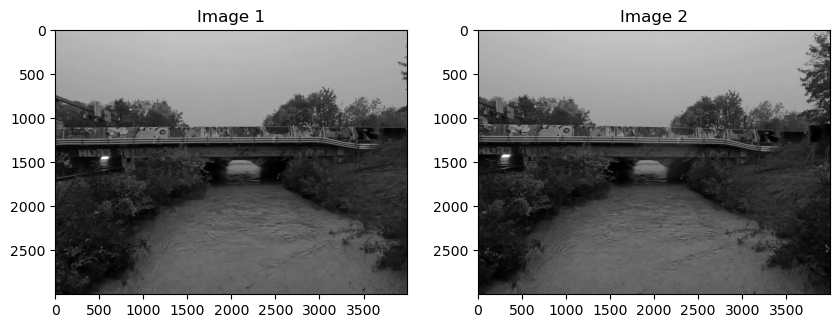

In [3]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

# Assuming you already have bw_images from the previous code

# Access the first two images
image1 = sx_images[0]
image2 = dx_images[0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Image 1')

# Plot the second image on the right subplot
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Image 2')

# Display the images side by side
plt.show()

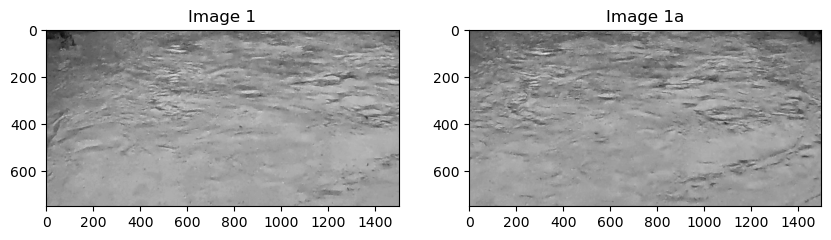

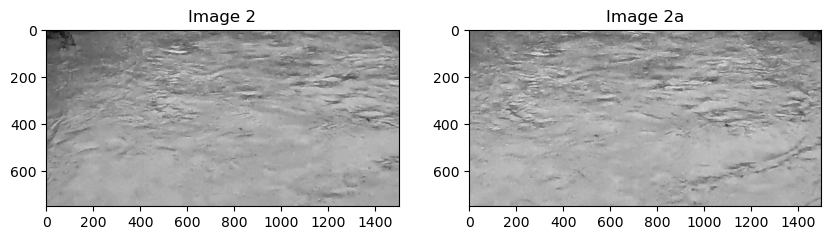

In [4]:
# Assuming you already have bw_images from the previous code

# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 1250
end_x = 2750
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

# Create an empty list to store the selected stripes
sx_stripes = []

# Loop through the images and select the stripe for each image
for img in sx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    sx_stripes.append(selected_stripe)

    dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image



# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(sx_stripes[0], cmap='gray')
axes[0].set_title('Image 1')

# Plot the second image on the right subplot
axes[1].imshow(dx_stripes[0], cmap='gray')
axes[1].set_title('Image 1a')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(sx_stripes[1], cmap='gray')
axes[0].set_title('Image 2')

# Plot the second image on the right subplot
axes[1].imshow(dx_stripes[1], cmap='gray')
axes[1].set_title('Image 2a')

# Display the images side by side
plt.show()

In [21]:
print(len(dx_stripes))

175


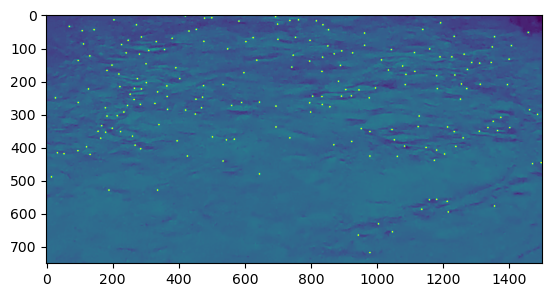

(<matplotlib.image.AxesImage at 0x157b34f90>, None)

In [5]:
nb_points = 200
corners = cv2.goodFeaturesToTrack(dx_stripes[0], nb_points,0.01,20)
corners = np.intp(corners)
 
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),3,255,-1)
 
plt.imshow(img_circles),plt.show()

In [6]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    return NCC

In [7]:
# 1. on recupere les coordonnées :
print(corners[:,0,:2].ravel().shape)
coord_track = corners[:,0,:2].ravel().reshape(nb_points,2)
x,y = coord_track[0, :]
print(x,y)

(400,)
852 93


In [8]:
def tracking(x0,y0,image, NCC):
    match = 1
    x1 = 0
    y1 = 0
    for x in range(x0-7, x0+7): 
        for y in range(y0-7, y0+7):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, 1)
            if res < match: 
                match = res
                x1 = x
                y1 = y
    return(x1, y1)

In [9]:
displacement = np.zeros((nb_points,20,2))
point_i = 0
point_delete = []
for x,y in coord_track: # bug sur le deuxieme point parce que (479,9) trop proche du bord de l'image... donc peut pas check les 15 pixels autour...
    for i in range(1, 21):
        if x< 11 or x > 1489 or y < 11 or y > 714: 
            #stock les points à enlever
            point_delete= np.append(point_delete, point_i)
            break #skip au prochain point
        NCC = NCC_window(x,y, dx_stripes[i-1])
        displacement[point_i, i-1 ,:]= x,y
        x,y = tracking(x,y, dx_stripes[i], NCC)
    point_i += 1
point_delete= point_delete.astype(int)
displacement = np.delete(displacement,point_delete,0 )

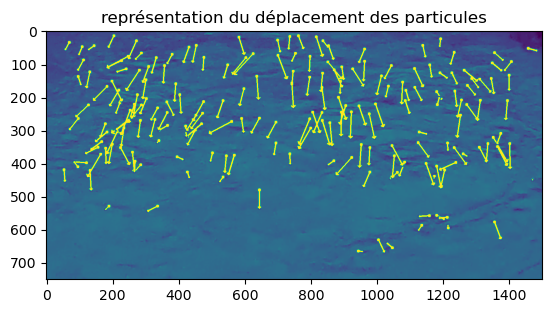

(<matplotlib.image.AxesImage at 0x157bf0f90>, None)

In [10]:
img_circles = dx_stripes[0].copy()
for i in range(displacement.shape[0]):
    x0,y0 = displacement[i,0,:]
    cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
    x1,y1 = displacement[i,14,:]
    cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
    cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 4)

plt.title('représentation du déplacement des particules')
plt.imshow(img_circles),plt.show()

In [11]:
stats = pd.DataFrame(columns =['x0', 'y0', 'x14', 'y14', 'vertical_anlge', 'length_[px]'])
direction = []
length = []
for i in range(displacement.shape[0]):
    x0,y0 = displacement[i,0,:]
    x1,y1 = displacement[i,14,:]
    if y1-y0 == 0: 
        break
    angle = np.arctan((x1-x0)/(y1-y0))
    intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
    direction = np.append(direction, angle)
    length= np.append(length, intensity)

x0 = displacement[:,0,0]
y0 = displacement[:,0,1]
x1 = displacement[:,14,0]
y1 = displacement[:,14,1]
stats['x0'] = x0
stats['y0'] = y0
stats['x14'] = x1
stats['y14'] = y1
stats['vertical_anlge'] = direction
stats['length_[px]']= length


In [12]:
display(stats[['vertical_anlge', 'length_[px]']].describe())

,vertical_anlge,length_[px]
count,189.000000,189.000000
mean,-0.093252,47.927993
std,0.564636,17.973017
min,-1.506369,1.000000
25%,-0.471460,35.000000
50%,-0.099669,49.979996
75%,0.309703,60.074953
max,1.494024,86.214848


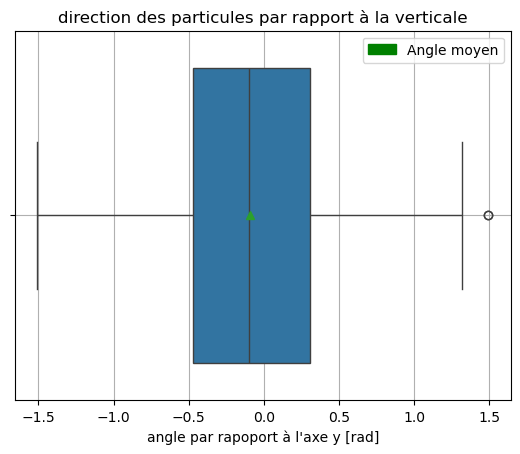

In [13]:
#boxplot= stats.boxplot(column = ['vertical_anlge'])
sns.boxplot(x="vertical_anlge", showmeans=True, data=stats)
#sns.despine(bottom=True)
mean_patch = mpatches.Patch(color='green', label='Angle moyen')
plt.legend(handles=[mean_patch], loc='upper right')
plt.xlabel("angle par rapoport à l'axe y [rad]")
plt.title("direction des particules par rapport à la verticale")
plt.grid(True)
plt.show()

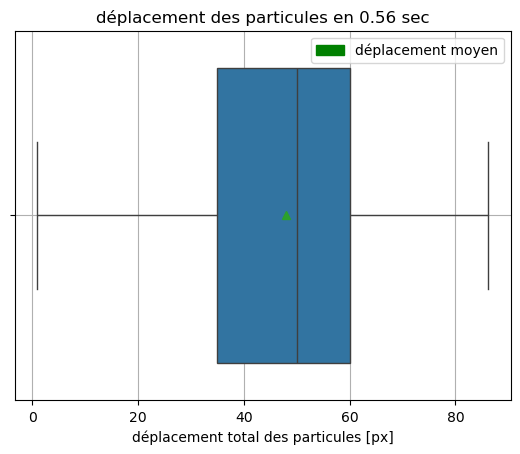

In [14]:
#boxplot= stats.boxplot(column = ['vertical_anlge'])
sns.boxplot(x="length_[px]", showmeans=True, data=stats)
#sns.despine(bottom=True)
mean_patch = mpatches.Patch(color='green', label='déplacement moyen')
plt.legend(handles=[mean_patch], loc='upper right')
plt.xlabel("déplacement total des particules [px]")
plt.title("déplacement des particules en 0.56 sec")
plt.grid(True)
plt.show()

In [15]:
def find_outliers_IQR(df):
   q1=stats.quantile(0.25)
   q3=stats.quantile(0.75)
   IQR=q3-q1
   not_outliers = stats[~((stats<(q1-1.5*IQR)) | (stats>(q3+1.5*IQR)))]
   outliers_dropped = not_outliers.dropna().reset_index(drop=True)
   return outliers_dropped

In [16]:
clean_df = find_outliers_IQR(stats[['vertical_anlge', 'length_[px]']])


In [17]:
print(clean_df[clean_df['length_[px]']< 15])

         x0     y0     x14    y14  vertical_anlge  length_[px]
13   1174.0  439.0  1173.0  445.0       -0.165149     6.082763
46    190.0  529.0   180.0  539.0       -0.785398    14.142136
48    341.0  331.0   336.0  337.0       -0.694738     7.810250
101  1261.0  371.0  1273.0  378.0        1.042722    13.892444
145  1471.0  449.0  1471.0  450.0        0.000000     1.000000
157  1216.0  595.0  1215.0  587.0        0.124355     8.062258


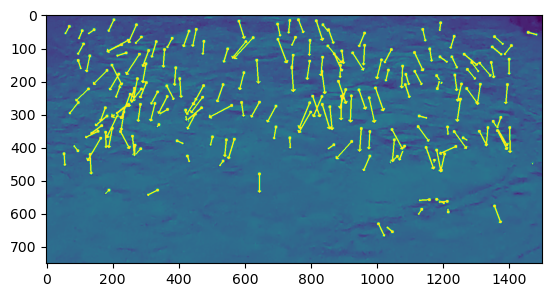

(<matplotlib.image.AxesImage at 0x157c0d9d0>, None)

In [18]:
img_arrow = dx_stripes[0].copy()
center_x0 = clean_df.x0.astype(int).to_numpy()
center_y0= clean_df.y0.astype(int).to_numpy()
center_x1 = clean_df.x14.astype(int).to_numpy()
center_y1 = clean_df.y14.astype(int).to_numpy()
for i in range(len(center_x0)):
    cv2.circle(img_arrow,(center_x0[i],center_y0[i]),5,255,-1)
    cv2.circle(img_arrow,(center_x1[i],center_y1[i]),5,(70,255,212),-1)
    cv2.arrowedLine(img_arrow, (center_x0[i],center_y0[i]), (center_x1[i],center_y1[i]), 255, 4)
plt.imshow(img_arrow),plt.show()